# 基于Mindspore实现AC算法

# 环境配置

mindspore 1.8.0
gym 0.21.0

# AC算法简介

Actor 基于概率分布选择行为, Critic 基于 Actor 生成的行为评判得分, Actor 再根据 Critic 的评分修改选行为的概率。

优点：AC方法牺牲了一点偏差，但能够有效降低方差；
缺点：Actor的行为取决于 Critic 的Value，但Critic难收敛，与actor一起更新就更难收敛。
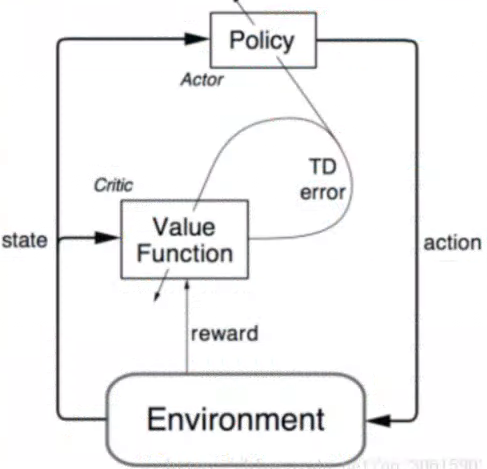

In [2]:
# 指定gym版本 默认最新版会出错
pip install gym==0.21.0

Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [6]:
import gym
import os
import mindspore
import mindspore.nn as nn
from mindspore.ops import function as F
import numpy as np
from mindspore import Tensor

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
env=gym.make('CartPole-v1').unwrapped
state_number=env.observation_space.shape[0]
action_number=env.action_space.n
round_num = 10    # 训练回合数 
LR_A = 0.005    # learning rate for actor
LR_C = 0.01     # learning rate for critic
Gamma = 0.9

class MAELoss(nn.LossBase):
    """自定义损失函数MAELoss"""
    def __init__(self, reduction="none"):
        super(MAELoss, self).__init__(reduction)
    def construct(self, prob, a,td):
        a_constant=a
        log_prob = F.log(prob)
        td_constant=td[0]
        log_prob_constant=-log_prob[0][a_constant]
        actor_loss = -log_prob_constant * td_constant
        return actor_loss
    
class ActorNet(nn.Cell):
    '''ActorNet'''
    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Dense(state_number, 50)
        self.fc2 = nn.Dense(50, 20)
        self.fc3 = nn.Dense(20, action_number)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()
    def construct(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.fc3(x)
        return self.softmax(x)

class CriticNet(nn.Cell):
    '''CriticNet'''
    def __init__(self):
        super(CriticNet, self).__init__()
        self.fc1 = nn.Dense(state_number, 50)
        self.fc2 = nn.Dense(50, 20)
        self.fc3 = nn.Dense(20, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()

    def construct(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return self.fc3(x)

class Actor():
    def __init__(self):
        self.actor=ActorNet()
        self.optimizer = nn.Adam(self.actor.trainable_params(),learning_rate=LR_A)
        self.loss=MAELoss()

    def choose(self,inputstate):
        # inputstate=Tensor(inputstate)
        inputstate=Tensor([inputstate])
        probs=self.actor(inputstate).asnumpy()
        action=np.random.choice(np.arange(action_number),p=probs[0])
        return action
    def learn(self,s,a,td):
        s = Tensor([s])
        prob = self.actor(s)
        # log_prob = F.log(prob)
        td=Tensor(td)
        a=int(a)
        a_constant = a
        log_prob = F.log(prob)
        td_constant = td[0]
        log_prob_constant = -log_prob[0][a_constant]

        loss_net=nn.WithLossCell(self.actor,loss_fn=self.loss(prob,Tensor(a),td))
        train_net = nn.TrainOneStepCell(loss_net,self.optimizer)




class Critic():
    def __init__(self):
        self.critic=CriticNet()
        self.tempA=ActorNet()

        self.optimizer = nn.Adam(self.critic.trainable_params(),learning_rate=LR_C)
        self.lossfunc=nn.MSELoss()#均方误差（MSE）
    def learn(self,s,r,s_):
        s = Tensor([s])
        v=self.critic(s)#输入当前状态，有网络得到估计v
        r=Tensor([r])
        s_ = Tensor([s_])
        temp=Tensor(self.critic(s_).asnumpy())
        reality_v=r+Gamma*temp[0]#现实v
        loss_net=nn.WithLossCell(self.critic,self.lossfunc(reality_v,v[0]))
        train_net=nn.TrainOneStepCell(loss_net,self.optimizer)
        advantage=(reality_v-v).asnumpy()

        return advantage

print('AC训练中...')
a=Actor()
c=Critic()
for i in range(round_num):
    r_totle=[]
    observation = env.reset() #环境重置
    while True:
        action=a.choose(observation)
        print(env.step(action))
        observation_, reward, done, info = env.step(action)
        td_error =c.learn(observation,reward,observation_)
        a.learn(observation,action,td_error)
        observation=observation_
        r_totle.append(reward)
        if done:
            break
    r_sum=sum(r_totle)
    print("\r回合数：{} 奖励：{}".format(i,r_sum),end=" ")
    if i%100==0 and i > int(round_num/2):
        mindspore.save_checkpoint(a.actor, "./actor.ckpt")
        mindspore.save_checkpoint(c.critic, "./critic.ckpt")


AC训练中...
(array([ 0.02173915,  0.1587873 , -0.04049886, -0.28830364], dtype=float32), 1.0, False, {})
(array([ 0.03200415,  0.16001782, -0.05813452, -0.3157213 ], dtype=float32), 1.0, False, {})
(array([ 0.03451991, -0.22837135, -0.06528742,  0.22974885], dtype=float32), 1.0, False, {})
(array([ 0.02150243, -0.61671877, -0.05066955,  0.7740997 ], dtype=float32), 1.0, False, {})
(array([-0.00705412, -1.0057464 , -0.01417917,  1.3318527 ], dtype=float32), 1.0, False, {})
(array([-0.05118278, -1.0057137 ,  0.04485919,  1.331291  ], dtype=float32), 1.0, False, {})
(array([-0.08752076, -1.0071785 ,  0.09254453,  1.3672138 ], dtype=float32), 1.0, False, {})
(array([-0.13173091, -1.0097804 ,  0.1536358 ,  1.4342737 ], dtype=float32), 1.0, False, {})
(array([-0.16826354, -1.0138043 ,  0.20618686,  1.5371192 ], dtype=float32), 1.0, False, {})
回合数：0 奖励：9.0 (array([ 0.02753312,  0.23161395, -0.04019781, -0.33169127], dtype=float32), 1.0, False, {})
(array([ 0.04071109,  0.623027  , -0.05956713, -